# 1-Rank Piecewise Warping

This notebook simulates data with linear piecewise warping using real data.
It adds in noise, amplitude jumps, and partial amplitude jumps.

In [7]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import copy
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
currentdir = os.path.dirname(os.path.realpath('Fig3_RealData.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

#### Generate simulate datasets from a piecewise warped model.

#### Load Real Dataset

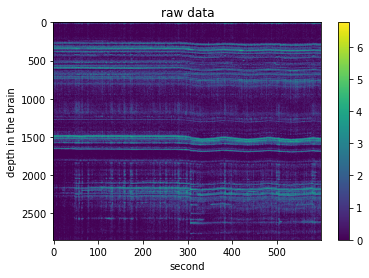

In [10]:
# load real data
data = np.load('data/data_1of_a_second.npy').T
data=np.log(1+data)
data=np.expand_dims(data, axis=2)

# Plot data.
plt.imshow(np.squeeze(data).T, aspect='auto')
plt.title('raw data'), plt.xlabel('second'), plt.ylabel('depth in the brain')
plt.colorbar()

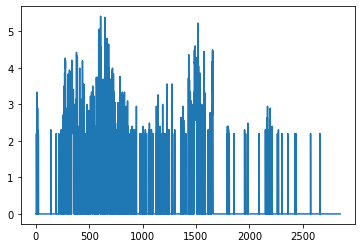

In [4]:
plt.figure
plt.plot(np.squeeze(data[3,:,:]))

#### 1) Data with iid Gaussian noise, standard deviation equal to data's nonzero entries' standard deviation

In [5]:
datasets={}

In [6]:
print(np.std(data[3,:,:]))

1.1365284614199802


In [7]:
from affinewarp.datasets import piecewise_warped_data

template_real=data[3,:,:]
noise_scale=np.std(template_real[template_real>0])*0.2

binned, true_model = piecewise_warped_data(
    n_knots=2,
    knot_mutation_scale=0.01,
    n_trials=50,
    n_neurons=1,
    clip_y_knots=True,
    template=template_real,
    noise_type="gaussian",
    noise_scale=noise_scale,
    seed=1234)
datasets['NoiseOnly']=[binned,true_model]

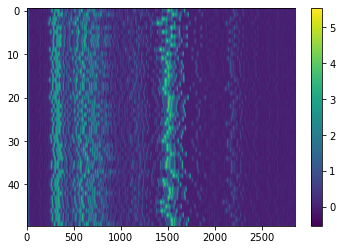

In [8]:
plt.imshow(np.squeeze(binned),aspect='auto')
plt.colorbar()

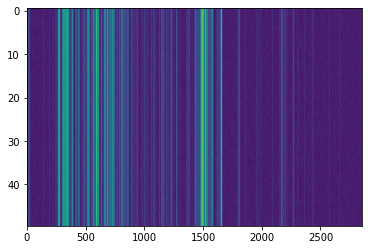

In [9]:
plt.imshow(np.squeeze(true_model.transform(binned)),aspect='auto')

In [8]:
template_real=data[3,:,:]
noises=[0.4,0.6,0.8,1]
for n in noises:
    noise_scale=np.std(template_real[template_real>0])*n

    binned, true_model = piecewise_warped_data(
        n_knots=2,
        knot_mutation_scale=0.01,
        n_trials=50,
        n_neurons=1,
        clip_y_knots=True,
        template=template_real,
        noise_type="gaussian",
        noise_scale=noise_scale,
        seed=1234)
    datasets['Noise_'+str(int(n*10))]=[binned,true_model]

#### 2) Generate a dataset with noise with ampitude modulation and jump from a piecewise warped model.

In [9]:
from affinewarp.datasets import piecewise_warped_data

data_=data[3,:,:]
template_real=data_

# Simulate Data with Noise
noise_scale=np.std(data_)*0.2
gain_scale=np.mean(data_[data_>0])*0.1
binned, true_model, gain = piecewise_warped_data(
    n_knots=2,
    n_trials=50,
    n_neurons=1,
    knot_mutation_scale=0.01,
    clip_y_knots=True,
    template=template_real,
    noise_type="gaussian",
    noise_scale=noise_scale,
    gain_scale=gain_scale,
    seed=1234)

# Add in amplitude jump
#K,T,N = np.shape(binned)
#rs1 = np.random.RandomState(1234+2)
#k_ind=rs1.choice(K, size=round(K*0.1), replace=False)
#gain = np.abs(rs1.normal(loc=1, scale=gain_scale*2, size=np.array([len(k_ind),1,N])))
#binned[k_ind,:,:]=binned[k_ind,:,:]*gain

datasets['NoiseAmp']=[binned,true_model,gain]

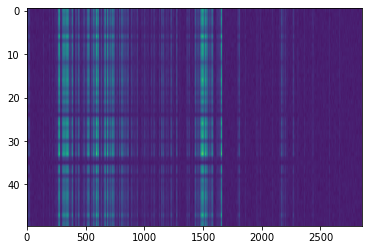

In [12]:
plt.imshow(np.squeeze(true_model.transform(binned)),aspect='auto')

#### 3) Generate a dataset with medium noise with ampitude modulation and jump (only in blocks of data) from a piecewise warped model.

In [10]:
from affinewarp.datasets import piecewise_warped_data

data_=data[3,:,:]
template_real=data_

# Simulate Data with Noise
noise_scale=np.std(data_)*0.2
gain_scale=np.mean(data_[data_>0])*0.1
binned, true_model,gain = piecewise_warped_data(
    n_knots=2,
    n_trials=50,
    n_neurons=1,
    clip_y_knots=True,
    knot_mutation_scale=0.01,
    template=template_real,
    noise_type="gaussian",
    noise_scale=noise_scale,
    gain_scale=gain_scale,
    seed=1234)

# Add in partial amplitude jump
K,T,N = np.shape(binned)
rs1 = np.random.RandomState(1234+2)
k_ind=rs1.choice(K, size=round(K*0.1), replace=False)
gain_ = np.abs(rs1.normal(loc=1, scale=gain_scale*2, size=np.array([len(k_ind),1,N])))

rs3 = np.random.RandomState(1234+3)
t_ind=rs3.choice(T-round(T*0.4), size=round(K*0.1), replace=False)
for k in range(len(k_ind)):
    binned[k_ind[k],t_ind[k]:t_ind[k]+round(T*0.3),:]=binned[k_ind[k],t_ind[k]:t_ind[k]+round(T*0.3),:]*gain[k]

datasets['NoiseAmpPartial']=[binned,true_model,gain]

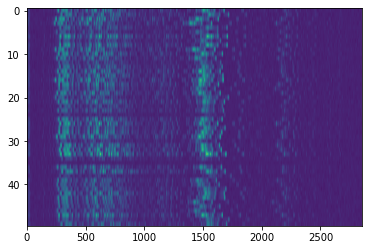

In [43]:
plt.imshow(binned,aspect='auto')

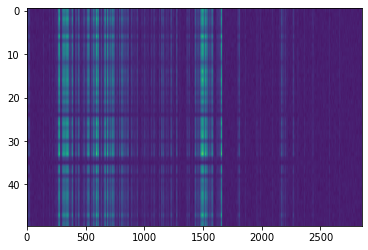

In [14]:
plt.imshow(np.squeeze(true_model.transform(binned)),aspect='auto')

In [15]:
datasets.keys()

dict_keys(['NoiseOnly', 'Noise_4', 'Noise_6', 'Noise_8', 'Noise_10', 'NoiseAmp', 'NoiseAmpPartial'])

#### (Explore a little bit about the difference between norm1 and norm2)

In [17]:
from affinewarp import PiecewiseWarping,Rank1_PiecewiseWarping
m=Rank1_PiecewiseWarping(n_knots=2, warp_reg_scale=1e-1, smoothness_reg_scale=0, loss='rank1_norm1')

In [18]:
m2=Rank1_PiecewiseWarping(n_knots=2, warp_reg_scale=1e-1, smoothness_reg_scale=0, loss='rank1_norm2')

In [19]:
m.fit(datasets['Noise_10'][0],iterations=100, warp_iterations=500)

Loss improvement: 25.36%: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


In [20]:
m2.fit(datasets['Noise_10'][0],iterations=100, warp_iterations=500)

Loss improvement: 49.13%: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


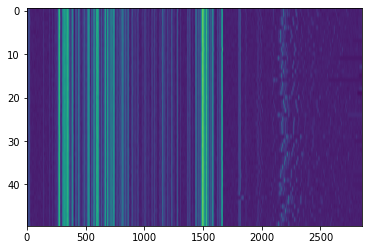

In [21]:
plt.imshow(m.transform(datasets['NoiseOnly'][0],init_warps=False),aspect='auto')

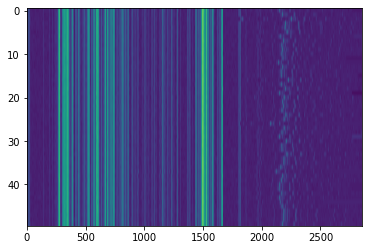

In [22]:
plt.imshow(m2.transform(datasets['NoiseOnly'][0],init_warps=False),aspect='auto')

#### From now on, only use norm2

#### A) Various Noise

In [11]:
from affinewarp import PiecewiseWarping,Rank1_PiecewiseWarping

Loss improvement: 49.19%: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


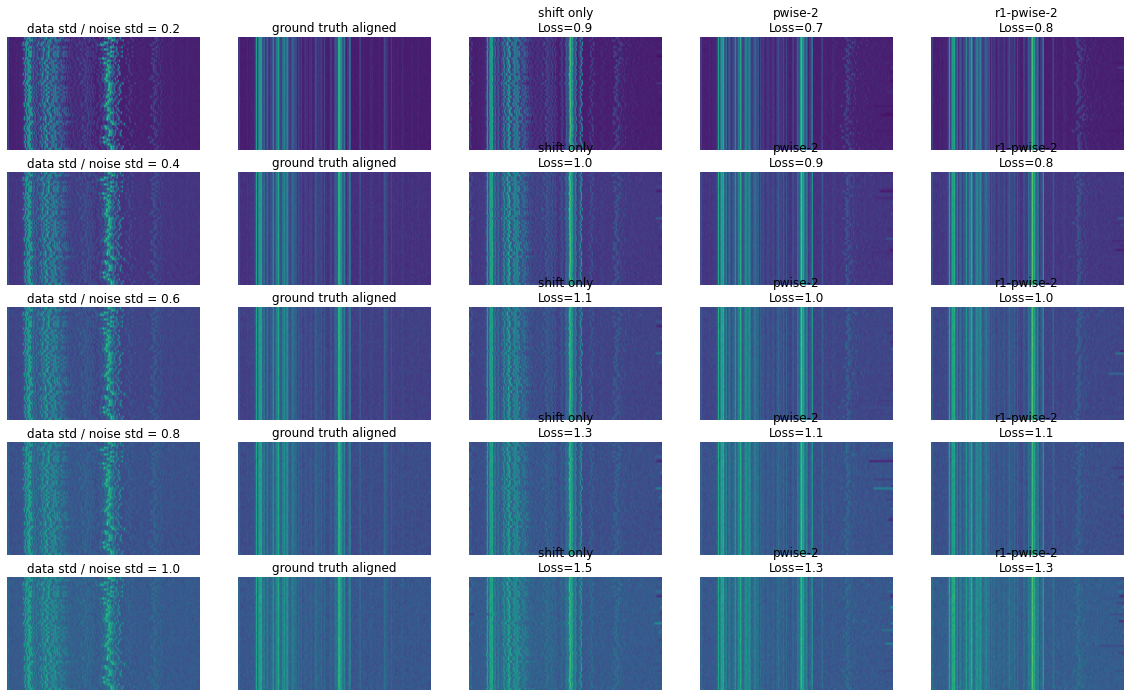

In [37]:
noises=[2,4,6,8,10]
models=[PiecewiseWarping(n_knots=0, warp_reg_scale=1e-1, smoothness_reg_scale=0),
        PiecewiseWarping(n_knots=2, warp_reg_scale=1e-1, smoothness_reg_scale=0),
        Rank1_PiecewiseWarping(n_knots=2, warp_reg_scale=1e-1, smoothness_reg_scale=0),
       ]
models_all={}
model_name=['shift only','pwise-2','r1-pwise-2']
fig,axes=plt.subplots(len(noises),5,sharex=True,sharey=False,figsize=(20, 12))
for n_ind in range(len(noises)):
    n=noises[n_ind]
    if n==2:
        key='NoiseOnly'
    else:
        key='Noise_'+str(n)
    data=datasets[key][0]
    true_model=datasets[key][1]
    models_all[key]=[]
    axes[n_ind,0].imshow(data,aspect='auto')
    axes[n_ind,0].set_title(f'data std / noise std = {round(n*0.1,1)}')
    axes[n_ind,0].axis('off')
    
    axes[n_ind,1].imshow(true_model.transform(data),aspect='auto')
    axes[n_ind,1].set_title('ground truth aligned')
    axes[n_ind,1].axis('off')
    
    for m_ind in range(len(models)):
        m=models[m_ind]
        test_model=copy.deepcopy(m)
        test_model.fit(data,iterations=100, warp_iterations=500)
        models_all[key].append(test_model)
        if isinstance(m, PiecewiseWarping):
            recon=test_model.transform(data)
            axes[n_ind,m_ind+2].imshow(recon,aspect='auto')
        else:
            recon=test_model.transform(data,init_warps=False)
            axes[n_ind,m_ind+2].imshow(recon,aspect='auto')
        loss_trans=round(np.mean((recon-true_model.transform(data))**2),1)
        axes[n_ind,m_ind+2].set_title(model_name[m_ind]+'\nLoss='+str(loss_trans))
        axes[n_ind,m_ind+2].axis('off')

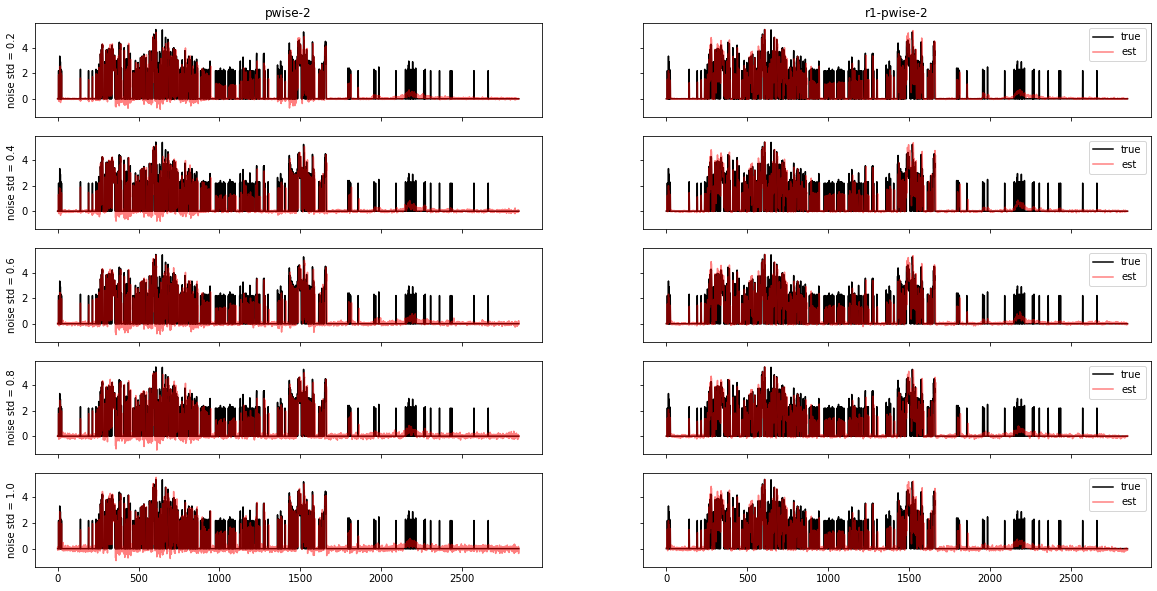

In [42]:
model_names=np.array(['shift only','pwise-2','r1-pwise-2'])

datasets_key=['NoiseOnly', 'Noise_4', 'Noise_6', 'Noise_8', 'Noise_10']
fig, axes = plt.subplots(len(datasets_key), 2, sharex=True, sharey=True, figsize=(20, 10))


for d in range(len(datasets_key)):
    key=datasets_key[d]
    models_list=models_all[key]
    true_model=copy.deepcopy(datasets[key][1])
    for model_ind in range(1,len(models_list)):
        ax=axes[d,model_ind-1]
        m=copy.deepcopy(models_list[model_ind])
        ax.plot(true_model.template, color='k', label='true')
        if isinstance(m, PiecewiseWarping):
            ax.plot(m.template, color='r', alpha=.5, label='est')
        else:
            modulation=np.max(m.template_u*np.mean(m.template_gain))/np.max(true_model.template)
            ax.plot(m.template_u*np.mean(m.template_gain)/modulation, color='r', alpha=.5, label='est')
        if d==0:
            ax.set_title(model_names[model_ind])
        if model_ind==1:
            n=noises[d]
            ax.set_ylabel(f'noise std = {round(n*0.1,1)}')

axes[0,-1].legend()  
axes[1,-1].legend()
axes[2,-1].legend()
axes[3,-1].legend()
axes[4,-1].legend()

#### B) Fit models and compare how they approximate the ground truth.

In [25]:
from affinewarp import PiecewiseWarping,Rank1_PiecewiseWarping
models=[PiecewiseWarping(n_knots=0, warp_reg_scale=1e-1, smoothness_reg_scale=0),
        PiecewiseWarping(n_knots=1, warp_reg_scale=1e-1, smoothness_reg_scale=0),
        PiecewiseWarping(n_knots=2, warp_reg_scale=1e-1, smoothness_reg_scale=0),
        PiecewiseWarping(n_knots=3, warp_reg_scale=1e-1, smoothness_reg_scale=0),
        Rank1_PiecewiseWarping(n_knots=1, warp_reg_scale=1e-1, smoothness_reg_scale=0),
        Rank1_PiecewiseWarping(n_knots=2, warp_reg_scale=1e-1, smoothness_reg_scale=0),
        Rank1_PiecewiseWarping(n_knots=3, warp_reg_scale=1e-1, smoothness_reg_scale=0)
       ]

Result_models={}
Result_loss_pred={}
Result_loss_trans={}
for key in list(datasets.keys()):
    binned=datasets[key][0]
    true_model=datasets[key][1]
    Result_models[key]=[]
    Result_loss_pred[key]=[]
    Result_loss_trans[key]=[]
    for m in models:
        model=copy.deepcopy(m)
        if isinstance(m, PiecewiseWarping):
            model.fit(binned,iterations=150, warp_iterations=400)
            loss=np.sum((model.predict()-binned)**2)
            loss_trans=np.sum((model.transform(binned)-true_model.transform(binned))**2)
        else:
            #model.fit(binned,iterations=150, warp_iterations=400,init_warps='shift')
            model.fit(binned,iterations=150, warp_iterations=400)
            loss=np.sum((model.predict(init_warps=False)-binned)**2)
            loss_trans=np.sum((model.transform(binned,init_warps=False)-true_model.transform(binned))**2)
            #loss=np.sum((model.predict(init_warps=True)-binned)**2)
            #loss_trans=np.sum((model.transform(binned,init_warps=True)-true_model.transform(binned))**2)
        Result_models[key].append(model)
        Result_loss_pred[key].append(loss)
        Result_loss_trans[key].append(loss_trans)

Loss improvement: 64.16%: 100%|██████████| 150/150 [01:24<00:00,  1.78it/s]


#### 1) Compare Loss

Text(0.5, 1.0, 'comparison of loss')

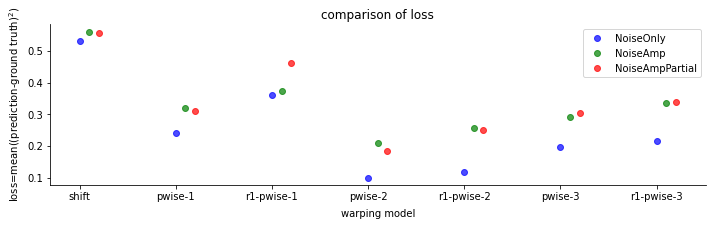

In [53]:
model_names=np.array(['shift','pwise-1', 'pwise-2', 'pwise-3','r1-pwise-1', 'r1-pwise-2', 'r1-pwise-3'])
model_perm=np.array([0,1,4,2,5,3,6]).astype('int')

datasets_key=['NoiseOnly', 'NoiseAmp', 'NoiseAmpPartial']
colors=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

Result_loss_pred2={}
for d in range(len(datasets_key)):
    key=datasets_key[d]
    models_list=Result_models[key]
    true_model=datasets[key][1]
    Result_loss_pred2[key]=[]
    for model_ind in range(len(models_list)):
        m=models_list[model_ind]
        if isinstance(m, PiecewiseWarping):
            pred=m.predict()
        else:
            pred=m.predict(init_warps=False)
        loss=np.mean((pred-true_model.predict())**2)
        Result_loss_pred2[key].append(loss)               

for d in range(len(datasets_key)):
    key=datasets_key[d]
    loss_list=np.array(Result_loss_pred2[key])[model_perm]
    plt.plot(np.arange(len(loss_list))+0.1*d, loss_list, 'o', color=colors[d],label=datasets_key[d], alpha=.7)
    #for loss_ind in range(len(loss_list)):
    #    m=models_list[loss_ind]
ax.set_xticks(np.arange(len(loss_list)))
ax.set_xticklabels(model_names[model_perm])

ax.set_ylabel("loss=mean((prediction-ground truth)$^2$)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('warping model', labelpad=7)
ax.legend()

fig.tight_layout()
ax.legend()
ax.set_title('comparison of loss')

#### 2) Compare true template to estimated template across some neurons

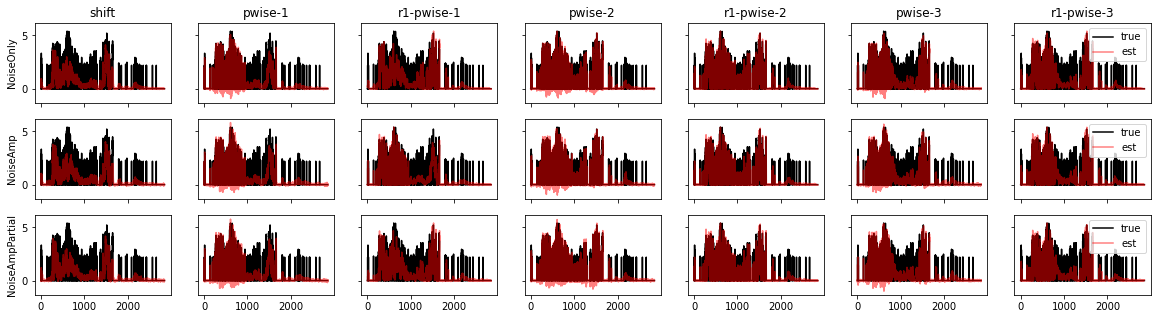

In [60]:
model_names=np.array(['shift','pwise-1', 'pwise-2', 'pwise-3','r1-pwise-1', 'r1-pwise-2', 'r1-pwise-3'])
model_perm=np.array([0,1,4,2,5,3,6]).astype('int')

datasets_key=['NoiseOnly', 'NoiseAmp', 'NoiseAmpPartial']
fig, axes = plt.subplots(len(datasets_key), 7, sharex=True, sharey=True, figsize=(20, 5))


for d in range(len(datasets_key)):
    key=datasets_key[d]
    models_list=Result_models[key]
    true_model=datasets[key][1]
    for model_ind in range(len(models_list)):
        ax=axes[d,model_ind]
        m=models_list[model_perm[model_ind]]
        ax.plot(true_model.template, color='k', label='true')
        if isinstance(m, PiecewiseWarping):
            ax.plot(m.template, color='r', alpha=.5, label='est')
        else:
            modulation=np.max(m.template_u*np.mean(m.template_gain))/np.max(true_model.template)
            ax.plot(m.template_u*np.mean(m.template_gain)/modulation, color='r', alpha=.5, label='est')
        if d==0:
            ax.set_title(model_names[model_perm][model_ind])
        if model_ind==0:
            ax.set_ylabel(key)

axes[0,-1].legend()  
axes[1,-1].legend()
axes[2,-1].legend()

#### 3) Compare rank-1-ness

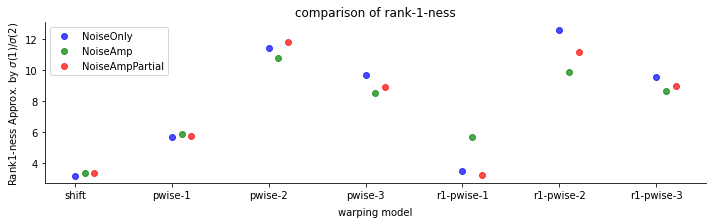

In [28]:
datasets_key=['NoiseOnly', 'NoiseAmp', 'NoiseAmpPartial']

Ratios_all={}
for d in range(len(datasets_key)):
    key=datasets_key[d]
    models_list=Result_models[key]
    true_model=datasets[key][1]
    ratios=[]
    for model_ind in range(len(models_list)):
        ax=axes[d,model_ind]
        m=models_list[model_ind]
        if isinstance(m, PiecewiseWarping):
            recon=m.transform(datasets[key][0])
        else:
            recon=m.transform(datasets[key][0],init_warps=False)
        u,s,vt=np.linalg.svd(np.squeeze(recon).T, full_matrices=False, compute_uv=True, hermitian=False)
        ratios.append(s[0]/s[1])
        #ratios.append(np.mean(m.loss_hist))
    Ratios_all[key]=ratios
        
## Plotting
model_names=np.array(['shift','pwise-1', 'pwise-2', 'pwise-3','r1-pwise-1', 'r1-pwise-2', 'r1-pwise-3'])
model_perm=np.array(np.arange(7)).astype('int')
datasets_key=['NoiseOnly', 'NoiseAmp', 'NoiseAmpPartial'] # datasets.keys() are ['NoiseOnly', 'NoiseAmp', 'NoiseAmpPartial']
colors=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
for d in range(len(datasets_key)):
    ratios=Ratios_all[datasets_key[d]]
    ratios_perm=np.array(ratios)[model_perm]
    plt.plot(np.arange(len(ratios_perm))+0.1*d, ratios_perm, 'o', color=colors[d],label=datasets_key[d], alpha=.7)

ax.set_xticks(np.arange(len(ratios_perm)))
ax.set_xticklabels(model_names[model_perm])

ax.set_ylabel("Rank1-ness Approx. by ${\sigma(1)}/{\sigma(2)}$")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('warping model', labelpad=7)
ax.legend()

fig.tight_layout()
ax.set_title('comparison of rank-1-ness')
ax.legend()

##### Some examples

11.817925112568144
11.164381719937019


Text(0.5, 0.98, 'Data: NoiseAmpPartial')

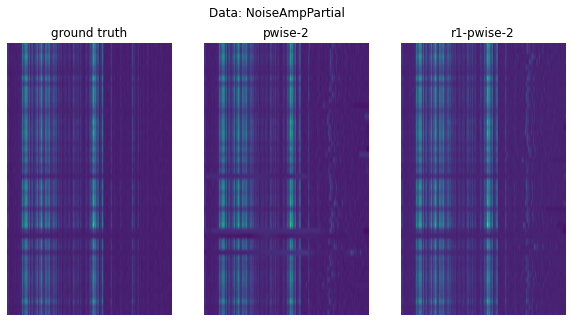

In [59]:
datakind='NoiseAmpPartial'
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 5))
gm=datasets[datakind][1]
recon_gt=gm.transform(datasets[datakind][0])
axes[0].imshow(recon_gt,aspect='auto')
axes[0].set_title('ground truth')
axes[0].axis('off')

m=Result_models[datakind][2]
recon=m.transform(datasets[datakind][0])
u,s,vt=np.linalg.svd(np.squeeze(recon).T, full_matrices=False, compute_uv=True, hermitian=False)
print(s[0]/s[1])
axes[1].imshow(recon,aspect='auto')
axes[1].set_title('pwise-2')
axes[1].axis('off')

m=Result_models[datakind][5]
recon=m.transform(datasets[datakind][0],init_warps=False)

u,s,vt=np.linalg.svd(np.squeeze(recon).T, full_matrices=False, compute_uv=True, hermitian=False)
print(s[0]/s[1])

axes[2].imshow(recon,aspect='auto')
axes[2].set_title('r1-pwise-2')
axes[2].axis('off')
fig.suptitle('Data: '+ datakind)

#### 4) Compare ground-truth and estimated amplitude modulation

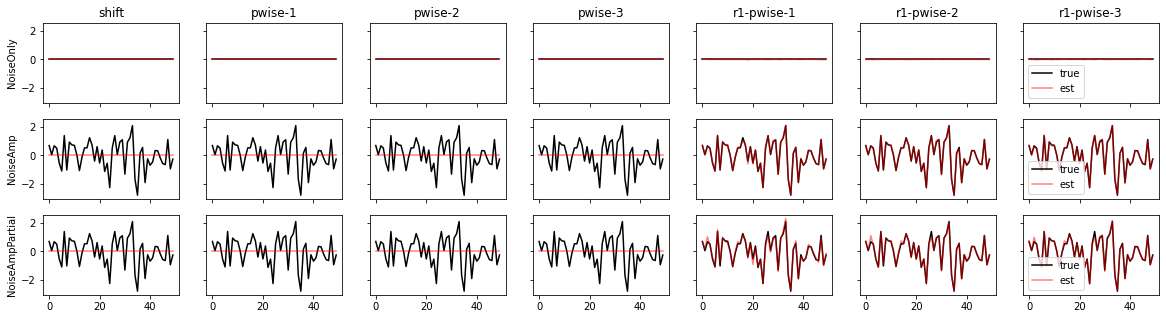

In [34]:
model_names=np.array(['shift','pwise-1', 'pwise-2', 'pwise-3','r1-pwise-1', 'r1-pwise-2', 'r1-pwise-3'])
model_perm=np.array([0,1,4,2,5,3,6]).astype('int')
datasets_key=['NoiseOnly', 'NoiseAmp', 'NoiseAmpPartial'] # datasets.keys() are ['NoiseOnly', 'NoiseAmp', 'NoiseAmpPartial']

fig, axes = plt.subplots(len(datasets_key), 7, sharex=True, sharey=True, figsize=(20, 5))

for d in range(len(datasets_key)):
    key=datasets_key[d]
    models_list=Result_models[key]
    true_model=datasets[key][1]
    for model_ind in range(len(models_list)):
        ax=axes[d,model_ind]
        m=models_list[model_ind]  
        if key=='NoiseOnly':
            ground_truth_modulation=np.ones(50)*np.mean(true_model.template)
            ax.plot(ground_truth_modulation-np.mean(ground_truth_modulation), color='k', label='true')
        else:
            ground_truth_modulation=np.squeeze(datasets[key][2])*np.mean(datasets[key][1].template)
            ax.plot((ground_truth_modulation-np.mean(ground_truth_modulation))/np.std(ground_truth_modulation), color='k', label='true')
        if isinstance(m, PiecewiseWarping):
            modulation=np.ones(50)*np.mean(m.template)
            ax.plot(modulation-np.mean(modulation), color='r', alpha=.5, label='est')
        else:
            #modulation=m.template_gain*(np.max(m.template_u))/np.max(datasets[key][1].template)
            modulation=m.template_gain*np.mean(m.template_u)   #np.mean(m.template_u)
            if key=='NoiseOnly':
                ax.plot((modulation-np.mean(modulation)), color='r', alpha=.5, label='est') 
            else:
                ax.plot((modulation-np.mean(modulation))/np.std(modulation), color='r', alpha=.5, label='est')
        if d==0:
            ax.set_title(model_names[model_ind])
        if model_ind==0:
            ax.set_ylabel(key)                

axes[0,-1].legend()  
axes[1,-1].legend()
axes[2,-1].legend()